In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/{filename}")
    df_list.append(df)

In [91]:

def extract_features(df):
    res = df["resistance"]
    dep = df["depth"]
    return pd.DataFrame([{
        "res_mean": res.mean(),
        "res_max": res.max(),
        "slope": res.max() / dep.max(),
        "depth_max": dep.max(),
        # "skew": res.skew(), # measure of right or left skew
        # "kurtosis": res.kurtosis(), # measure of tailness
    }])

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for df in df_list:
    representation_list.append(extract_features(df))
print(f"example: {representation_list[0]}")


example:     res_mean    res_max        slope  depth_max
0  21.169391  36.954578  8994.395778   0.004109


# Visualize Extracted Features

     res_mean    res_max         slope  depth_max
0   21.169391  36.954578   8994.395778   0.004109
1    7.837878  14.855126    907.126867   0.016376
2   19.835932  39.438614  23679.916399   0.001665
3   13.872044  24.235008   1014.137122   0.023897
4   14.619260  25.233179   1044.593718   0.024156
..        ...        ...           ...        ...
74  20.165880  39.657303   7554.855620   0.005249
75  20.234410  33.987297   2880.317950   0.011800
76   7.215493  11.055174    580.959778   0.019029
77   3.042483   5.722402    164.463622   0.034794
78  18.128656  33.702854   2485.693937   0.013559

[79 rows x 4 columns]


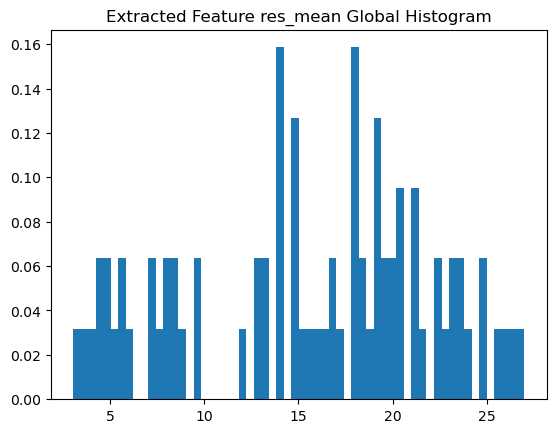

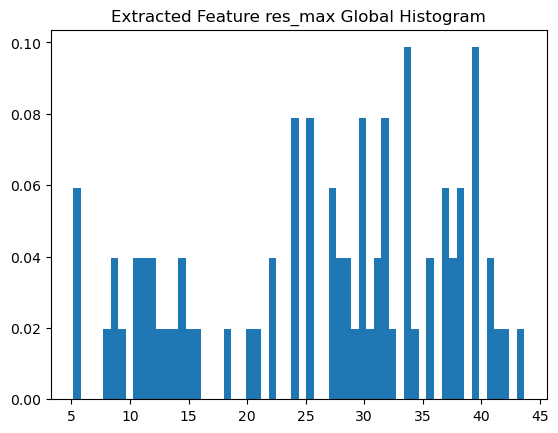

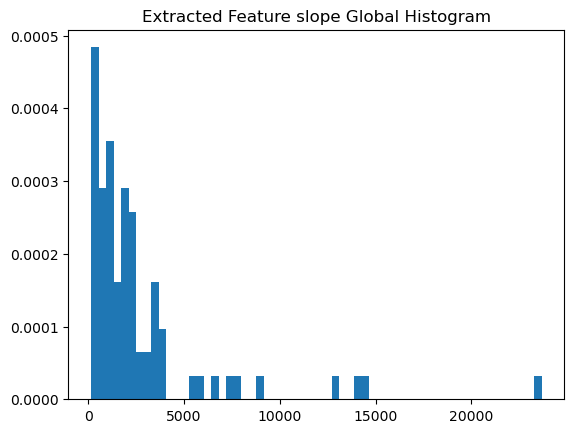

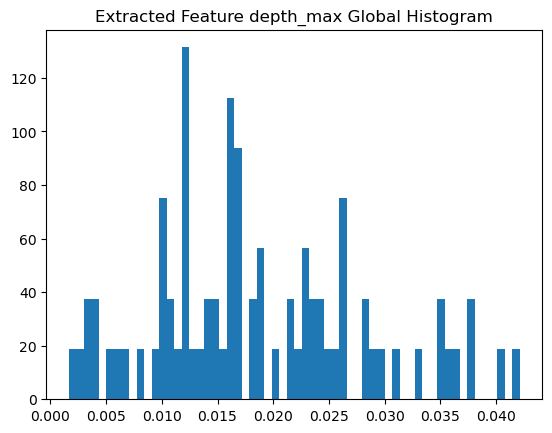

In [92]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
print(representation_df)
for col in representation_df.columns:
    plt.hist(representation_df[col], bins=60, density=True)
    plt.title(f"Extracted Feature {col} Global Histogram")
    plt.show()


# Scale Features

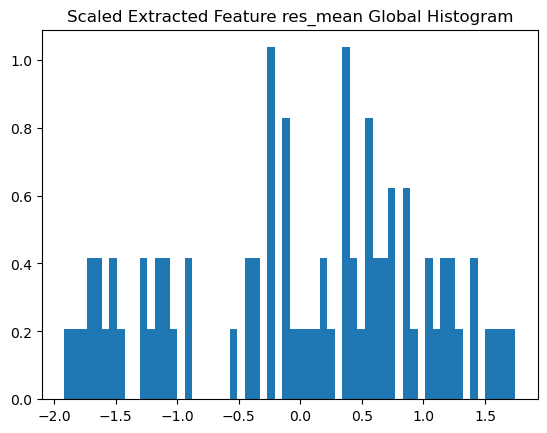

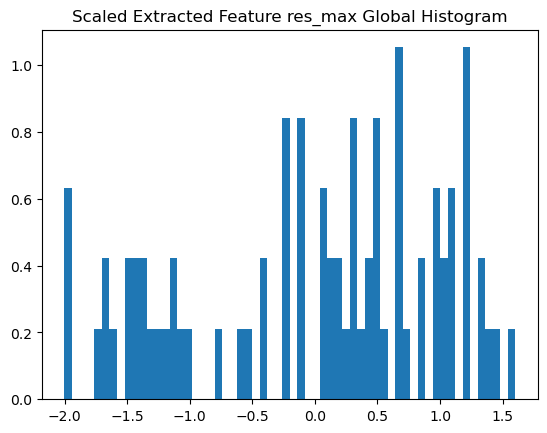

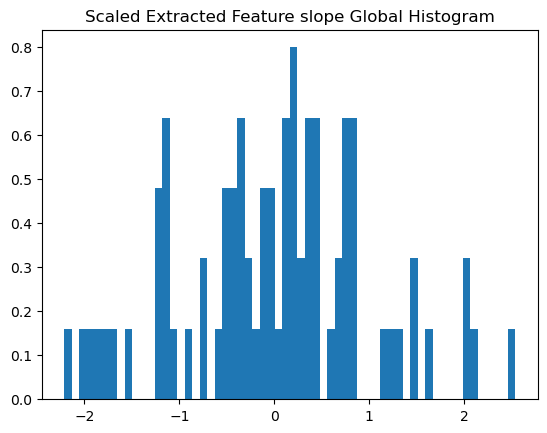

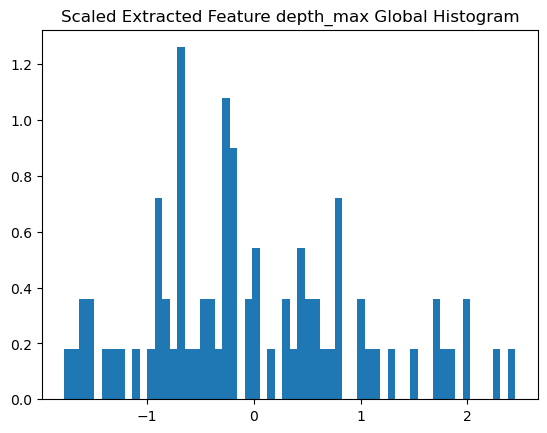

In [93]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "slope" in df.columns: df['slope'] = np.log(df['slope'])
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)

for col in scaled_representations.columns:
    plt.hist(scaled_representations[col], bins=60, density=True)
    plt.title(f"Scaled Extracted Feature {col} Global Histogram")
    plt.show()


## K-Means Clustering Implementation w/ k-means++ init for centroids

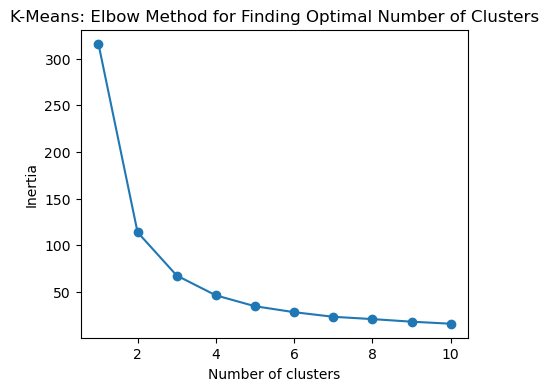

In [94]:
from sklearn.cluster import KMeans
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(scaled_representations)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(5,4))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# print(kmeans.labels_)

# kmeans.predict # for predicting which cluster a data point belongs too

# Visualization Functions

In [95]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters(representation_list, y_labels, use_pca=False, use_sne=False, two_d=False):
    """
    A linear method that projects your data into a new 2D coordinate system that captures maximum variance.
    It compresses the data while retaining its most important patterns.
    Fast and good for general structure.
    """
    if use_pca:
        pca = PCA(n_components=2) # reduce data down to 2 dims
        X_pca = pca.fit_transform(representation_list) # learns directions of max vairance, projects onto 2D
        # print(y_labels)
        plt.title("KMeans Clustering Visualized with pca")
        # x_pca: x_dim, x_pca: y_dim, c: color points based on clusters, cmap: color map
        # X_pca[:,0] -> 0th index of every row, X_pca[:,1] -> 1st index of every row
        plt.scatter(X_pca[:,0], X_pca[:,1], c=y_labels, cmap='viridis')
        plt.show()
    """
    A nonlinear technique focused on preserving local neighborhoods.
    Often shows tight, separated clusters, even when PCA shows overlapping blobs.
    """
    if use_sne:
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(np.array(representation_list))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels, cmap='coolwarm')
        plt.title("KMeans Clustering Visualized with t-SNE")
        plt.xlabel("t-SNE Feature 1")
        plt.ylabel("t-SNE Feature 2")
        plt.show()
    
    if len(representation_list.columns) == 2 and two_d:
        x = representation_list.columns[0]
        y = representation_list.columns[1]
        plt.scatter(representation_list[x], representation_list[y], c=y_labels, cmap="coolwarm")
        plt.title(f"KMeans Clustering: {x} and {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()


def display_curve(df_list, graph_i):
    plt.figure(figsize=(8,5))       
    plt.plot(df_list[graph_i]['depth'], df_list[graph_i]['resistance'], marker='o', linestyle='-')
    plt.xlabel('Depth')
    plt.ylabel('Resistance')
    plt.title('Resistance vs Depth')
    plt.show()

# display max 2 graphs per label
def visualize_cluster_curves(df_list, y_labels, max_num_graphs_per_cluster=2):
    # Index list
    df_list_i = list(range(len(df_list)))

    # Sort y_labels and indices together
    y_labels_sorted, df_list_sorted = zip(*sorted(zip(y_labels, df_list_i)))
    y_labels_sorted = list(y_labels_sorted)
    df_list_sorted = list(df_list_sorted)

    displayed_count = {}  # Track how many times we've displayed each label

    for i in range(len(y_labels_sorted)):
        label = y_labels_sorted[i]
        index = df_list_sorted[i]

        # Display at most 2 curves per label
        if displayed_count.get(label, 0) < max_num_graphs_per_cluster:
            print(f"y_label: {label}")
            display_curve(df_list, index)
            displayed_count[label] = displayed_count.get(label, 0) + 1


# K-Means Clustering

kmeans labels:
[0 4 0 3 3 3 2 3 2 2 1 2 2 3 1 2 2 1 2 0 2 1 4 3 0 0 2 1 0 4 1 1 0 2 3 3 2
 0 2 3 4 0 1 3 3 1 2 2 1 4 2 3 1 1 0 0 3 0 3 4 2 3 2 0 3 2 2 2 0 0 1 0 0 2
 0 2 4 1 2]


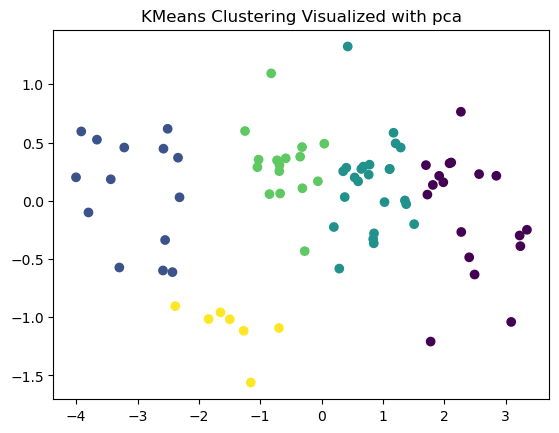

In [96]:
kmeans_elbow = 5
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(scaled_representations)
print(f"kmeans labels:\n{kmeans.labels_}")
visualize_clusters(scaled_representations, kmeans.labels_, use_pca=True, use_sne=False, two_d=True)
# visualize_cluster_curves(df_list, kmeans.labels_, max_num_graphs_per_cluster=2)

# Hierarchical Clustering

[75 56 67 78 70 46 74 65 47 71 54 49 68 50 44 73 72 33 45 76 69 51 55 77
 63 61 66 62 24 34 48 40 36 59 35 38 39 32 64 19 57 31 43 37 15 22 58 17
 27 60 28 42 30 16 29 13 18 23 11 21  8 41  7 20 14  6 53  9 52 26 10  4
 25  3 12  1  5  2  0]


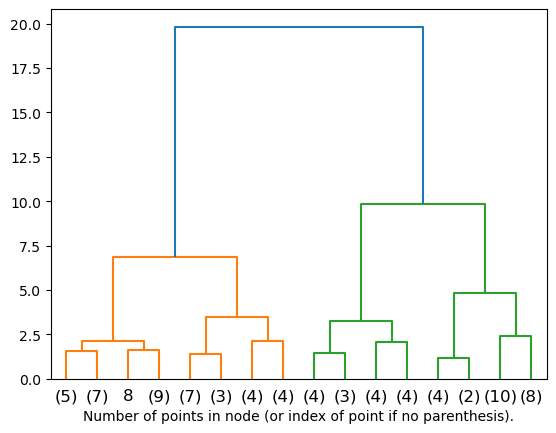

In [97]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hierarchical = hierarchical.fit(scaled_representations)
print(hierarchical.labels_)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
# no more than p levels o fthe dendrogram tree are displayed
plot_dendrogram(hierarchical, truncate_mode="level", p=3)
# plot_dendrogram(hierarchical, p=3)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()